<a href="https://colab.research.google.com/github/ucfilho/vichebling2810/blob/main/Fruta_Bexiga/frutas_bexiga_parte_08_nov_12_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# parte 1- le os arquivos e separa eles em a e b (a frutas deitadas e b sao as frusta em pe)
# parte 2- usa o filtro
# parte 3- calcula o volume : para um objeto
# parte 4- para todos objetos
# parte 5- explora tecnicas para melhorar o volume
# parte 6 - adiciona o volume falso como coluna para X tentativa de melhorar calc
# parte 7 - inicia calcular as areas
# parte 8- identica a parte 7 mas em rotina para duas orientacoes (up e down)

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os 
import cv2
import re, random
from skimage import feature
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

In [3]:
!gdown --id 1PbOf7-WA_t4FKOGkOgIi3dioOxaOr6Q_

Downloading...
From: https://drive.google.com/uc?id=1PbOf7-WA_t4FKOGkOgIi3dioOxaOr6Q_
To: /content/Bexigas.zip
100% 229M/229M [00:01<00:00, 140MB/s]


In [4]:
import zipfile
file_name = zipfile.ZipFile('Bexigas.zip', 'r')
file_name.extractall()

In [5]:
FILE='Bexigas.zip'
img_name=[]
x_original = [] 

ref ='jpg'
data_file ='xlsx'

with zipfile.ZipFile(FILE, "r") as f:
    for name in f.namelist():
      if(name[-3:]==ref):
        img_name.append(name)
        #x_original.append(cv2.resize(cv2.imread(name),(60,80)))
        x_original.append(cv2.resize(cv2.imread(name,0),(60,80)))
      else:
        if(name[-4:] == data_file):
          df =pd.read_excel(name)


In [6]:
name_down=[]  # down representa as frutas deitadas
original_down = [] 
name_up=[] # down representa as frutas em pe
original_up= [] 

In [7]:
k = 0
for name in img_name:
  if(name[-5]=='a'):
    name_up.append(name)
    original_up.append(x_original[k])
  else:
    name_down.append(name)
    original_down.append(x_original[k])
  k = k +1


In [8]:
def get_dimension(img):
  im = img
  # Compute the Canny filter for two values of sigma
  edges1 = feature.canny(im)
  edges2 = feature.canny(im, sigma=3)
  nrows,ncols =edges2.shape
  Foto = np.ones((nrows,ncols))*255
  for i in range(nrows):
    for j in range(ncols):
      if edges2[i,j] == True:
        Foto[i,j]=0
  Foto = Foto.astype(int)
# calculo do raio horizontal
  Quadrado = []
  Raio = []
  for i in range(nrows):
    values = np.zeros(4)
    k = -1
    for j in range(1,ncols):
      if(Foto[i,j-1]==255 and Foto[i,j]==0):
        if(k<3):
          k = k+1
          values[k]=j
    L = values[3] - values[0]
    d = values[2] - values[1]
    Quadrado.append(L)
    Raio.append(d)
  L = np.array(Quadrado).max()
  Raio = np.array(Raio).max()
  medida = Raio/L*14.5
  return medida,Foto


In [9]:
(num,l,w)=np.array(original_down).shape

In [10]:
dimensao =[]
for i in range(num):
  lista =[]
  Ind = i
  img= original_up[Ind]
  medida1,foto = get_dimension(img)
  lista.append(medida1)
  img = img.transpose()
  medida2,foto = get_dimension(img)
  lista.append(medida2)
  img2= original_down[Ind]
  medida3,foto = get_dimension(img2)
  lista.append(medida3)
  img2 = img2.transpose()
  medida4,foto = get_dimension(img2)
  lista.append(medida4)
  dimensao.append(lista)


In [11]:
def elipsoide(valores):
  dif = np.zeros(4)
  k = 0
  ref =1E99
  for i in range(2):
    for j in range(2):
      dif[k] = abs(valores[i]-valores[j+2])
      if(ref > dif[k]):
        ref = dif[k]
        ind1=i # 0,1
        ind2=j+2 # 2,3
      k = k+1
  b = (valores[ind1]+valores[ind2])/2
  if(ind1 ==0):
    a = valores[1]
  else:
    a = valores[0]
  if(ind2 ==2):
    c = valores[3]
  else:
    c = valores[2]
  Vol = 4/3*np.pi*a*b*c

  return Vol  
  

  

In [12]:
Volume = []
X =[]
for i in range(num):
  valores = dimensao[i]
  X.append(valores)
  Vol = elipsoide(valores)
  Volume.append(Vol)

In [13]:
#dimensao[0]

In [14]:
y = df['Volume'].values
#print(y)

In [15]:
X = np.array(X)
X =np.concatenate((X,np.array(Volume).reshape(num,1)),axis=1)
y = np.array(y)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10, shuffle=True, random_state=3)# 1

In [16]:
scaler_X = preprocessing.MinMaxScaler((-1,1)).fit(X)
scaler_Y = preprocessing.MinMaxScaler((-1,1)).fit(y)

In [17]:
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_Y.transform(y_train)
y_test = scaler_Y.transform(y_test)

In [18]:
# define a rede neural 
N_Hidden= 20
model = MLPRegressor(solver='lbfgs',activation='tanh',alpha=1e-5,hidden_layer_sizes=(N_Hidden), max_iter=1500,random_state=11 )

In [19]:
# treina a rede neural
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=20, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=11, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [20]:
# usa a rede neural treina em calculos para treino e teste
y_calc_train=model.predict(X_train)
y_calc_test=model.predict(X_test)

In [21]:
# transforma dos dados calculados na forma original (nao normatizado)
y_obs_train=scaler_Y.inverse_transform(np.array(y_train).reshape(-1,1))
y_obs_test=scaler_Y.inverse_transform(np.array(y_test).reshape(-1,1))
y_calc_train=scaler_Y.inverse_transform(y_calc_train.reshape(-1,1))
y_calc_test=scaler_Y.inverse_transform(y_calc_test.reshape(-1,1))

In [22]:
print(pd.DataFrame({'test calc':y_calc_test.ravel(),'test true':y_obs_test.ravel()}))

    test calc  test true
0   17.934313       64.0
1  159.313866       35.0
2  152.122191       50.0
3  158.414148       57.0
4   44.145921       28.0
5   43.783512       91.0
6   51.469472       39.0
7   80.936421       34.0
8  104.234913       81.0
9  277.055752       63.0


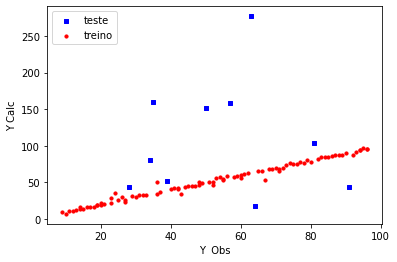

In [23]:
# expressa os dois dados em figura
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y_obs_test,y_calc_test, s=10, c='b', marker="s", label='teste')
ax1.scatter(y_obs_train,y_calc_train, s=10, c='r', marker="o", label='treino')
plt.legend(loc='upper left')
#plt.xlim([15,30])
#plt.ylim([15,30])
plt.ylabel('Y Calc')
plt.xlabel('Y  Obs')
plt.show()

In [24]:
mse=mean_squared_error(y_obs_test,y_calc_test)
print("MSE teste=",mse)
R2=r2_score(y_obs_test,y_calc_test)
print("R^2 teste=",R2)

MSE teste= 8949.808481159576
R^2 teste= -21.56861125973264


In [25]:
mse=mean_squared_error(y_obs_train,y_calc_train)
print("MSE treino=",mse)
R2=r2_score(y_obs_train,y_calc_train)
print("R^2 treino=",R2)

MSE treino= 10.164757682316644
R^2 treino= 0.9850573748078709


In [26]:
def area_fruta(img):
  (rows, cols) =img.shape

  img_fruit = np.zeros(img.shape,np.uint8) 

  for i in range(rows):
    for j in range(cols):
      if(img[i,j]>100):
        img[i,j]=0


  for i in range(rows):
    for j in range(cols):
      if(img[i,j]>0):
        img[i,j]=255
        img_fruit[i,j]=255

  xi=0;xf=0;yi=0;yf=0;
  jref=int(cols/2)
  iref=int(rows/2)

  for i in range(rows):
    j = jref
    if(img[i,j]>0):
      if(xi==0):
        xi = i
      else:
        xf = i
  for j in range(cols):
    i = iref
    if(img[i,j]>0):
      if(yi==0):
        yi = j
      else:
        yf = j

  for i in range(rows):
    for j in range(cols):
      if(i > xi and i < xf and j>yi and j < yf):
        img[i,j]=255

    area = 1-np.sum(img_fruit.ravel())/np.sum(img.ravel())

  return area

In [27]:
area_up =[]
area_down =[]
for i in range(num):
  lista =[]
  Ind = i
  img= original_up[Ind]
  area = area_fruta(img)
  area_up.append(area)
  img= original_down[Ind]
  area = area_fruta(img)
  area_down.append(area)

In [28]:
print(area_up)

[0.14885496183206104, 0.19602698650674666, 0.12139605462822456, 0.12443095599393017, 0.13572778827977316, 0.10839694656488552, 0.10218140068886339, 0.09938837920489296, 0.07390300230946878, 0.09337466098411473, 0.1214230471771075, 0.12259800153727907, 0.09343629343629345, 0.12634822804314327, 0.145616067979915, 0.10528345545699958, 0.06254709871891484, 0.06160954948016939, 0.0906656465187452, 0.14071510957324107, 0.048461538461538445, 0.0565819861431871, 0.08905165767154977, 0.1307037896365043, 0.07557251908396945, 0.12811660912926737, 0.09399075500770415, 0.06994619523443502, 0.1210363495746326, 0.10674373795761083, 0.13711857860177679, 0.11880046136101496, 0.08349365140438625, 0.08842752787389463, 0.05809926894959605, 0.06461538461538463, 0.08630609896432684, 0.09919261822376013, 0.13522858240491742, 0.1376811594202898, 0.04854740061162077, 0.06791301030141172, 0.09334353481254787, 0.07639419404125292, 0.09827915869980874, 0.10377718428080884, 0.06233269598470359, 0.06498470948012236

In [29]:
print(area_down)

[0.18368902439024393, 0.1741444866920152, 0.14830346930995042, 0.1428571428571429, 0.1492424242424243, 0.11362778406946017, 0.11178247734138969, 0.1145557655954631, 0.10164310278945354, 0.11816443594646275, 0.14, 0.1609627679578789, 0.11544342507645255, 0.1462585034013606, 0.1724528301886793, 0.12888551933282788, 0.08053435114503815, 0.03523554193795486, 0.09916413373860178, 0.1648351648351648, 0.03883121876201456, 0.06069919323857087, 0.09687261632341726, 0.1641961231470923, 0.06770635222518062, 0.15993964541682382, 0.06912267375617165, 0.058020477815699634, 0.14043035107587765, 0.13036868110984412, 0.17751034223392248, 0.15074798619102414, 0.09527468305801001, 0.11017274472168903, 0.0688196847366398, 0.07574598316755932, 0.10450038138825324, 0.11573720397249809, 0.15522501906941266, 0.17861205915813427, 0.06176134197483796, 0.08152380952380955, 0.10858010630220194, 0.08731966590736517, 0.12021236253318168, 0.1332828474062855, 0.0666412795125666, 0.07771428571428574, 0.127044503613541